In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import pyspark
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("PySpark").getOrCreate()
spark

In [2]:
from pyspark.sql import functions as F
from pyspark.sql.types import *

In [3]:
def printdf(df, l=5):
    return df.limit(l).toPandas()

def nullcount(df):
    return {col: df.filter(df[col].isNull()).count() for col in df.columns}

def shape(df):
    print((df.count(), len(df.columns)))

# Load data

In [4]:
data = spark.read.csv("OnlineRetail.csv", inferSchema=True, header=True)

# Prepare data

In [5]:
# Prepare customer data
# Filters:
#     Country = UK
#     Quantity > 0

rtl_data = (
    data.filter(F.col("Country") == "United Kingdom")
    .filter(F.col("CustomerID").isNotNull())
    .filter(F.col("Quantity") > 0)
    .withColumn("TotalAmount", F.col("Quantity") * F.col("UnitPrice"))
    .withColumn("InvoiceDate", F.to_date(F.col("InvoiceDate"), 'MM/dd/yyyy'))
)

rtl_customer_data = (
    rtl_data.groupBy(["CustomerID", "InvoiceNo", "InvoiceDate"])
    .agg(F.sum("TotalAmount").alias("TotalAmount"),
         F.sum("Quantity").alias("Quantity"),
         F.sum("UnitPrice").alias("UnitPrice"))
)

# printdf(rtl_customer_data)
# rtl_customer_data.toPandas().describe()

In [6]:
# rtl_data.printSchema()

# Compute RFM

In [7]:
# Prepare Recency, Frequency, Monetary data

latest_date = F.to_date(F.lit("2011/12/10"), 'yyyy/MM/dd')

# Create RFM Modelling scores for each customer
rfm_scores = (
    rtl_customer_data.groupBy("CustomerID")
                     .agg((F.datediff(latest_date, F.max(F.col("InvoiceDate")))).alias("Recency"),
                           F.count(F.col("InvoiceNo")).alias("Frequency"),
                           F.sum(F.col("TotalAmount")).alias("Monetary"))
)

# rfm_scores = rfm_scores.join(rtl_customer_data, "CustomerID", "left")

# printdf(rfm_scores)

In [8]:
# rfm_scores.toPandas().describe()

# RFM Score Calculation

In [19]:
# Identify the quantiles

quantiles = rfm_scores.approxQuantile(["Recency", "Frequency", "Monetary"], [0.25, 0.5, 0.75], 0)
quantiles

[[18.0, 51.0, 143.0],
 [1.0, 2.0, 5.0],
 [300.03999999999996, 651.8199999999999, 1575.8899999999999]]

In [10]:
# Calculate R,F,M vavlues considering quantiles

rfm_scores = rfm_scores.withColumn("R", 
                                   F.when(F.col("Recency") < quantiles[0][0], F.lit(1))
                                    .when(F.col("Recency") < quantiles[0][1], F.lit(2))
                                    .when(F.col("Recency") < quantiles[0][2], F.lit(3))
                                    .otherwise(F.lit(4)))\
                       .withColumn("F",
                                   F.when(F.col("Frequency") < quantiles[1][0], F.lit(4))
                                    .when(F.col("Frequency") < quantiles[1][1], F.lit(3))
                                    .when(F.col("Frequency") < quantiles[1][2], F.lit(2))
                                    .otherwise(F.lit(1)))\
                       .withColumn("M",
                                   F.when(F.col("Monetary") < quantiles[2][0], F.lit(4))
                                    .when(F.col("Monetary") < quantiles[2][1], F.lit(3))
                                    .when(F.col("Monetary") < quantiles[2][2], F.lit(2))
                                    .otherwise(F.lit(1)))

# printdf(rfm_scores.filter(F.col("CustomerID").isin([12346,12747,12748,12749,12820])))
# rfm_scores.toPandas().describe()

In [12]:
# Aggregate RFM scores

rfm_agg_scores = (
    rfm_scores.groupBy("CustomerID")
    .agg((F.first("R") + F.first("F") + F.first("M")).alias("RFMScore"),
         F.concat(
            F.first("R").cast(StringType()), 
            F.first("F").cast(StringType()), 
            F.first("M").cast(StringType())).alias("RFMScoreGroup"))
    .join(rfm_scores, "CustomerID", "left")
)

# printdf(rfm_agg_scores)
# rfm_agg_scores.toPandas().describe()
shape(rfm_agg_scores)

(3921, 9)


# Inspect

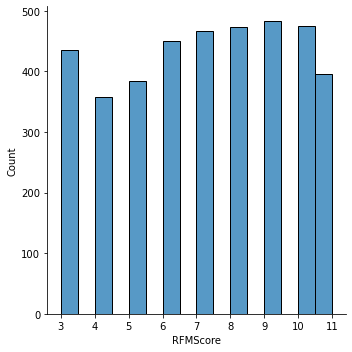

In [17]:
# RFM Score Distribution (lower the score is, valuable the customer is)

sns.displot(rfm_agg_scores.toPandas()["RFMScore"])

In [20]:
quantiles = rfm_agg_scores.approxQuantile("RFMScore", [0.25, 0.5, 0.75], 0)
quantiles

[5.0, 7.0, 9.0]

In [75]:
# Assign loyalty level to each customer

loyalty_level = ['Platinum', 'Gold', 'Silver', 'Bronze']

rfm_loyalty = rfm_agg_scores.withColumn("Loyalty",
                                        F.when((F.col("RFMScore") <= quantiles[0]), F.lit(loyalty_level[0]))
                                         .when((F.col("RFMScore") <= quantiles[1]), F.lit(loyalty_level[1]))
                                         .when((F.col("RFMScore") <= quantiles[2]), F.lit(loyalty_level[2]))
                                         .otherwise(F.lit(loyalty_level[3])))

# printdf(rfm_loyalty.filter(F.col("CustomerID").isin([12346,12747,12748,12749,12820])))
# printdf(rfm_loyalty.filter(F.col("RFMScoreGroup") == "111"), 10)
shape(rfm_loyalty)

(3921, 10)


In [68]:
# printdf(rfm_loyalty)

In [69]:
rfm_loyalty.toPandas().describe()

,CustomerID,RFMScore,Recency,Frequency,Monetary,R,F,M
count,3921.000000,3921.000000,3921.000000,3921.000000,3921.000000,3921.000000,3921.000000,3921.000000
mean,15561.471563,7.106095,92.722265,4.246111,1863.910113,2.519000,2.087478,2.499617
std,1576.823683,2.532436,99.528532,7.205750,7481.922217,1.108505,0.770799,1.118291
min,12346.000000,3.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000
25%,14208.000000,5.000000,18.000000,1.000000,300.040000,2.000000,1.000000,1.000000
50%,15569.000000,7.000000,51.000000,2.000000,651.820000,3.000000,2.000000,2.000000
75%,16913.000000,9.000000,143.000000,5.000000,1575.890000,4.000000,3.000000,3.000000
max,18287.000000,11.000000,374.000000,210.000000,259657.300000,4.000000,3.000000,4.000000


In [25]:
# rfm_loyalty_df = rfm_loyalty.toPandas()

In [31]:
# fig, ax = plt.subplots(1, 3, figsize=(11.7, 8.27))

# sns.histplot(rfm_loyalty_df.query("Loyalty == 'Platinum' and Frequency < 50")['Frequency'], kde=True, ax=ax[0])
# sns.histplot(rfm_loyalty_df.query("Loyalty == 'Gold' and Frequency < 50")['Frequency'], kde=True, ax=ax[1])
# sns.histplot(rfm_loyalty_df.query("Loyalty == 'Silver' and Frequency < 50")['Frequency'], kde=True, ax=ax[2])
# fig.show()

In [70]:
# Inspect RFM

# fig, ax = plt.subplots(1, 1, figsize=(11.7, 8.27))
# sns.displot(rfm_loyalty_df["Loyalty"])

# fig.show()

<hr>

# K-Means Clustering

In [76]:
# Since log transformation doesn't work with negative and zero values, lets get rid of negative and zeros

rfm_data = (
    rfm_loyalty.withColumn("Monetary", F.when(F.col("Monetary") <= 0, 1).otherwise(F.col("Monetary")))
#                .withColumn("Recency", F.when(F.col("Recency") <= 0, 1).otherwise(F.col("Recency")))
#                .withColumn("Frequency", F.when(F.col("Frequency") <= 0, 1).otherwise(F.col("Frequency")))
)
# printdf(rfm_loyalty)

In [77]:
# Perform Log transformation to bring data into normal or near normal distribution

rfm_data = (
    rfm_data.withColumn("Recency_log", F.log10(F.col("Recency")))
            .withColumn("Monetary_log", F.log10(F.col("Monetary")))
            .withColumn("Frequency_log", F.log10(F.col("Frequency")))
)
# printdf(rfm_loyalty)

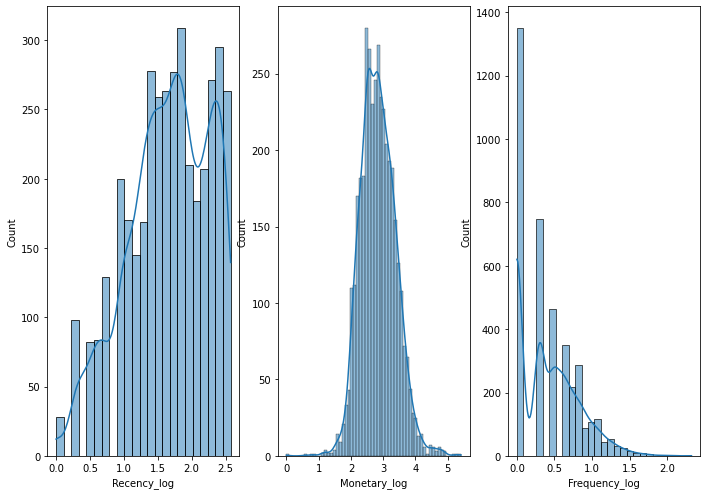

In [78]:
rfm_data_df = rfm_data.toPandas()

fig, ax = plt.subplots(1, 3, figsize=(11.7, 8.27))
sns.histplot(rfm_data_df['Recency_log'], kde=True, ax=ax[0])
sns.histplot(rfm_data_df['Monetary_log'], kde=True, ax=ax[1])
sns.histplot(rfm_data_df['Frequency_log'], kde=True, ax=ax[2])
plt.show()